In [1]:
import torch
import torchvision.models as models
from pathlib import Path
import os
import glob
import cv2
import numpy as np
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchsummary import summary
from utils import pytorchtools
%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [3]:
learning_rate = 1e-5
num_epochs = 100
patience = 5
batch_size = 80

In [4]:
#Chest X-Ray Images (Pneumonia)
DATA_DIR = Path("chest_xray\\")

TRAIN_P_DIR = DATA_DIR/'train/PNEUMONIA'
TRAIN_N_DIR = DATA_DIR/'train/NORMAL'

TEST_P_DIR = DATA_DIR/'test/PNEUMONIA'
TEST_N_DIR = DATA_DIR/'test/NORMAL'

VAL_P_DIR = DATA_DIR/'val/NORMAL'
VAL_N_DIR = DATA_DIR/'val/PNEUMONIA'

In [5]:
# Get the list of all the images
TRAIN_P = TRAIN_P_DIR.glob('*.jpeg')
TRAIN_N = TRAIN_N_DIR.glob('*.jpeg')

TEST_P = TEST_P_DIR.glob('*.jpeg')
TEST_N = TEST_N_DIR.glob('*.jpeg')

VAL_P = VAL_P_DIR.glob('*.jpeg')
VAL_N = VAL_N_DIR.glob('*.jpeg')

TRAIN_DATA = []
TEST_DATA = []
VAL_DATA = []

for i in TRAIN_P:
    TRAIN_DATA.append((i,1))
for i in TRAIN_N:
    TRAIN_DATA.append((i,0))
    
for i in TEST_P:
    TEST_DATA.append((i,1))
for i in TEST_N:
    TEST_DATA.append((i,0))

for i in VAL_P:
    VAL_DATA.append((i,1))
for i in VAL_N:
    VAL_DATA.append((i,0))

# Transform array to Pandas Dataframe
TRAIN_DATA = pd.DataFrame(TRAIN_DATA, columns=['image', 'label'],index=None)
TRAIN_DATA = TRAIN_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

TEST_DATA = pd.DataFrame(TEST_DATA, columns=['image', 'label'],index=None)
TEST_DATA = TEST_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

VAL_DATA = pd.DataFrame(VAL_DATA, columns=['image', 'label'],index=None)
VAL_DATA = VAL_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

In [6]:
# #CoronaHack -Chest X-Ray-Datase
# DATA_DIR_2 = Path("dataset_2\\")
# CSV_PATH = DATA_DIR_2/'labels.csv'
# IMAGE_PATH = str(DATA_DIR_2)+"\\train\\"

# data = pd.read_csv(CSV_PATH)
# data.drop('Unnamed: 0', axis=1, inplace=True)
# # Preview the first 5 lines of the loaded data 
# ct = data.loc[(data['Label'] == "Normal") & (data['Dataset_type'] == "TRAIN")]
# ct = ct.drop(['Label', 'Dataset_type','Label_2_Virus_category','Label_1_Virus_category'], axis=1)
# ct = ct.rename(columns={'X_ray_image_name':'image'})
# ct['label'] = 0
# ct['path'] = IMAGE_PATH
# ct["image"] = ct["path"] + ct["image"]
# ct = ct.drop(["path"], axis=1)
# # ct.head(5)
# print(len(ct))

In [7]:
print(TRAIN_P_DIR)

chest_xray\train\PNEUMONIA


In [8]:
# TRAIN_DATA = pd.concat([TRAIN_DATA, ct])
# print(TRAIN_DATA)

In [9]:
print(f'There are {len(TRAIN_DATA)} elements in train set')
print(f'There are {len(TEST_DATA)} elements in test set')
print(f'There are {len(VAL_DATA)} elements in validation set')

There are 5216 elements in train set
There are 624 elements in test set
There are 16 elements in validation set


1    3875
0    1341
Name: label, dtype: int64


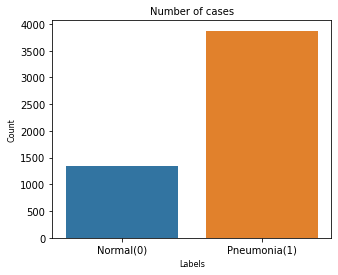

1    8
0    8
Name: label, dtype: int64


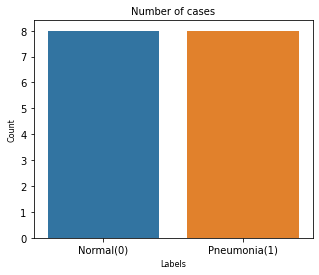

1    390
0    234
Name: label, dtype: int64


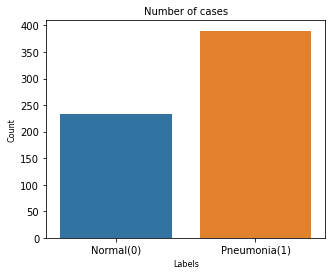

In [10]:
for x in [TRAIN_DATA, VAL_DATA, TEST_DATA]:
  # Get the counts for each class
  cases_count = x['label'].value_counts()
  print(cases_count)

  # Plot the results 
  plt.figure(figsize=(5,4))
  sns.barplot(x=cases_count.index, y= cases_count.values)
  plt.title('Number of cases', fontsize=10)
  plt.xlabel('Labels', fontsize=8)
  plt.ylabel('Count', fontsize=8)
  plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
  plt.show()

In [11]:
labels = {
    0: 'Normal',
    1: 'Pneumonia'
}

In [12]:
# full_data = pd.concat([TRAIN_DATA,VAL_DATA], ignore_index=True)
# full_data = full_data.sample(frac=1.,random_state=17).reset_index(drop=True)

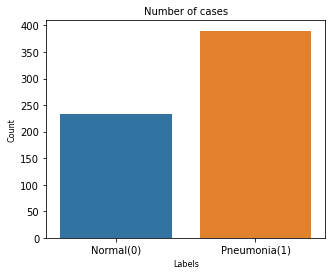

In [13]:
# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=10)
plt.xlabel('Labels', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [14]:
class PneumoniaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_fname, img_label = row['image'], row['label']
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        return img, img_label

In [15]:
train_transform = T.Compose([T.Resize((256,256)),
                             T.RandomAffine(30),
                             T.ColorJitter(),
                             T.ToTensor()])
val_transform = T.Compose([T.Resize((256,256)),
                           T.ToTensor()])

In [16]:
train_df = TRAIN_DATA.reset_index()
val_df = VAL_DATA.reset_index()
test_df = TEST_DATA.reset_index()

In [17]:
train_dataset = PneumoniaDataset(train_df, transform=train_transform)
test_dataset = PneumoniaDataset(test_df, transform=train_transform)
val_dataset = PneumoniaDataset(val_df, transform=val_transform)

In [18]:
# PyTorch data loaders
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=4).permute(1, 2, 0))
        break

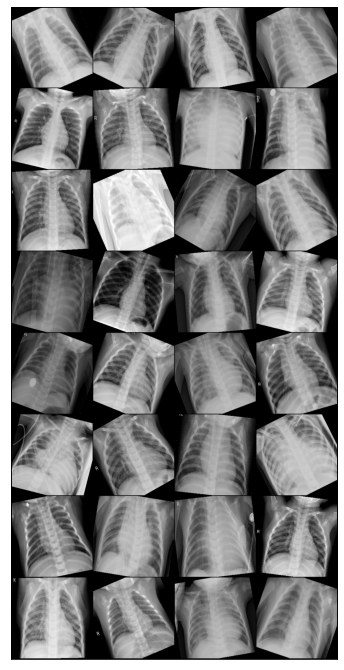

In [20]:
show_batch(train_dl)

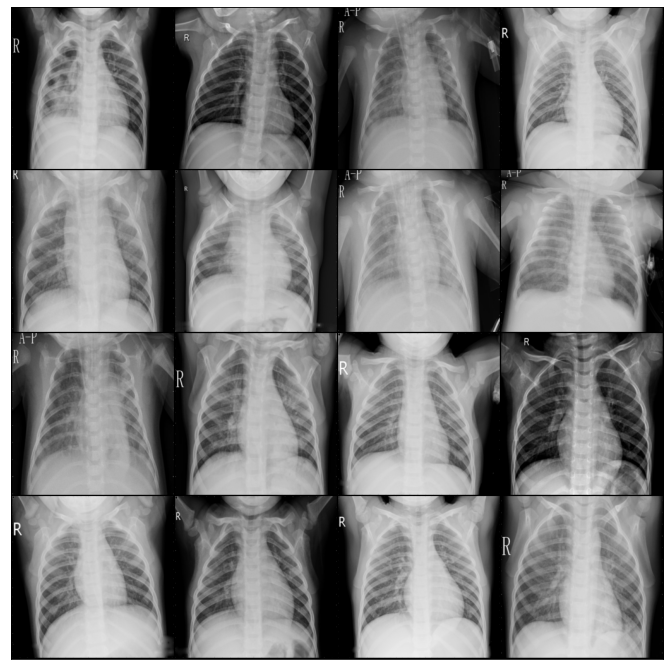

In [21]:
show_batch(val_dl)

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Move to GPU

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Loss and Optimizer

In [25]:
model = models.resnet50(pretrained=True)

In [26]:
for param in model.parameters():
    param.requires_grad = False 

In [27]:
# Replace last layer        
# num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(num_features, 2))

In [28]:
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)
running_loss = 0
losses = []

## Freeze the residual layers


In [30]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [31]:
# To freeze the residual layers
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.fc.parameters():
#     param.requires_grad = True

In [32]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,770,562 total parameters.
262,530 training parameters.


In [76]:
# initialize the early_stopping object
model.eval()
early_stopping = pytorchtools.EarlyStopping(patience=patience, verbose=True)
for epoch in range(num_epochs):
    ##########################    
    #######TRAIN MODEL########
    ##########################
    epochs_loss=0
#     model.train()
    for i, (images, labels) in enumerate(train_dl):
        # Move tensors to the configured device
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #calculate train_loss
        train_losses.append(loss.item())
    
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    for images, labels in val_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
#     print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = (f'train_loss: {train_loss:.5f} ' + f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)
    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

train_loss: 0.49620 valid_loss: 0.96122
Validation loss decreased (inf --> 0.961216).  Saving model ...
0
train_loss: 0.43268 valid_loss: 1.04105
EarlyStopping counter: 1 out of 5
1
train_loss: 0.38709 valid_loss: 1.08541
EarlyStopping counter: 2 out of 5
2
train_loss: 0.35056 valid_loss: 1.15831
EarlyStopping counter: 3 out of 5
3


KeyboardInterrupt: 

## Unfreeze model

In [ ]:
for param in model.parameters():
            param.require_grad = True

In [ ]:
# initialize the early_stopping object
early_stopping = pytorchtools.EarlyStopping(patience=patience, verbose=True)

for epoch in range(num_epochs):
    ##########################    
    #######TRAIN MODEL########
    ##########################
    epochs_loss=0
    for i, (images, labels) in enumerate(train_dl):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #calculate train_loss
        train_losses.append(loss.item())
    
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in val_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
#     print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = (f'train_loss: {train_loss:.5f} ' + f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)

    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

## Loss function vs Epoch

In [ ]:

fig = plt.figure()

######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")

h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)


## Test the model

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_3.ckpt')